In [12]:
import logging
import pickle

import torch
import torch.distributions
import torch.nn.functional as F

import matplotlib.pyplot as plt

import dca
import utils

logging.basicConfig(level=logging.INFO)

In [2]:
aligned_msa_fullpath = "../sequence_sets/mDHFR_clean.fasta.gz"
weights_fullpath = "../working/mDHFR_clean_weights.npy"

In [3]:
msa, msa_weights = dca.load_full_msa_with_weights(
                    msa_path=aligned_msa_fullpath,
                    convert_unknown_aa_to_gap=False)
N,L,q = msa.shape
print(f"MSA shape: {msa.shape}, MSA weights shape: {msa_weights.shape}")

INFO:root:weights_path is none. Setting all weights to 1.
INFO:root:Weights are not specified in dataloader. Setting equal weights.
INFO:root:... [NOTE] when training the model, Check to see if sampling is weighted
INFO:root:Data.shape = torch.Size([23266, 186, 21])
INFO:root:Weights.shape = torch.Size([23266])


MSA shape: torch.Size([23266, 186, 21]), MSA weights shape: torch.Size([23266])


## ArDCA

In [4]:
def get_entropy_column_order(msa, msa_weights):
    """Return the index of site residue positions in increasing entropy order"""
    with torch.no_grad():
        f_i_a = (msa * msa_weights[:, None, None]).sum(axis=0) / N
        entropy = torch.distributions.Categorical(probs=f_i_a).entropy()

        # Sort in ascending order (most conserved columns first)
        entropy_argsort = entropy.argsort()
        return entropy_argsort

class ArDCA(dca.DCA):

    """Auto regressive method to estimate probability dist"""

    def __init__(self, col_order, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # indices for the lower triangular part of the 4d interaction array
        # we use this to zero out paramters between (i,a) and (j,b) when j <= i
        self.row_lower, self.col_lower = torch.tril_indices(self.ncol, self.ncol)
        self.col_order = col_order

    def forward(self, x):
        x_msa = x
        # FIXME is this necessary
        self.weights = self.w * 1 # make a copy through multiplication
        self.weights[self.row_lower, :, self.col_lower, :] *= 0
        x_logit = torch.tensordot(x_msa, self.weights, 2) + self.bias
        return x_logit
      
    def reorder_msa(self, msa):
        """reorder msa columns to match column order """
        msa_reorder = msa[:, self.col_order, :]
        msa_cat_reorder = msa_reorder.argmax(dim=2) # type LongTensor
        return msa_reorder, msa_cat_reorder
        
    @classmethod
    def create_ardca_model(cls, msa, msa_weights, *args, **kwargs):
        col_order = get_entropy_column_order(msa=msa, msa_weights=msa_weights)
        return cls.create_dca_model(col_order=col_order, msa=msa, 
                                        msa_weights=msa_weights)




In [5]:
model = ArDCA.create_ardca_model(msa, msa_weights)
msa_reorder, msa_cat_reorder = model.reorder_msa(msa)

In [6]:
learning_rate = 0.01
num_epochs = 100
verbose=True

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_step = ArDCA.make_train_step(model, ArDCA.create_loss_function(), optimizer)

In [8]:
losses = []
for epoch in range(num_epochs):
    loss = train_step(x=msa_reorder, x_weights=msa_weights, x_cat=msa_cat_reorder)
    losses.append(loss)
    if verbose:
        logging.info(f"Epoch: {epoch:02d} Loss={loss:.2f}")

INFO:root:Epoch: 00 Loss=851.48
INFO:root:Epoch: 01 Loss=663.46
INFO:root:Epoch: 02 Loss=545.14
INFO:root:Epoch: 03 Loss=472.45
INFO:root:Epoch: 04 Loss=425.72
INFO:root:Epoch: 05 Loss=392.11
INFO:root:Epoch: 06 Loss=367.14
INFO:root:Epoch: 07 Loss=347.62
INFO:root:Epoch: 08 Loss=330.58
INFO:root:Epoch: 09 Loss=315.79
INFO:root:Epoch: 10 Loss=303.62
INFO:root:Epoch: 11 Loss=293.47
INFO:root:Epoch: 12 Loss=284.64
INFO:root:Epoch: 13 Loss=276.84
INFO:root:Epoch: 14 Loss=270.05
INFO:root:Epoch: 15 Loss=264.17
INFO:root:Epoch: 16 Loss=258.94
INFO:root:Epoch: 17 Loss=254.07
INFO:root:Epoch: 18 Loss=249.42
INFO:root:Epoch: 19 Loss=244.99
INFO:root:Epoch: 20 Loss=240.83
INFO:root:Epoch: 21 Loss=236.97
INFO:root:Epoch: 22 Loss=233.42
INFO:root:Epoch: 23 Loss=230.16
INFO:root:Epoch: 24 Loss=227.18
INFO:root:Epoch: 25 Loss=224.42
INFO:root:Epoch: 26 Loss=221.79
INFO:root:Epoch: 27 Loss=219.24
INFO:root:Epoch: 28 Loss=216.77
INFO:root:Epoch: 29 Loss=214.42
INFO:root:Epoch: 30 Loss=212.22
INFO:roo

In [9]:

ret = {'losses':losses, 'model':model, 'optimizer':optimizer,
        'weights': model.weights.detach().numpy(),
        'bias': model.bias.detach().numpy(),
        'col_order':model.col_order.detach().numpy()
                }


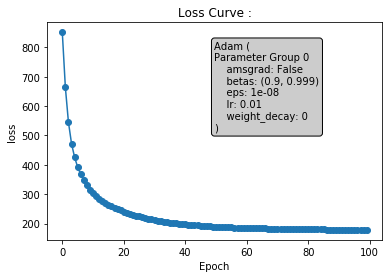

In [11]:
utils.plot_loss_curve(losses=ret['losses'],
        annotatation_str = str(ret['optimizer']),
        #save_fig_path = config.lossgraph_fullpath,
        #model_name= config.model_name
        )

In [13]:
with open("../working/mDHFR_clean_dca_params.pkl", 'wb') as fh:
    pickle.dump({k:ret[k] for k in ["weights", "bias", "col_order"]}, fh)